# Objective
In this version of the code we want to change the types slightly such that constants are more easily incorporated, such that they don't have to be calculated each time.

# Types

In [17]:
using Distributions

# Constants
const two_pi = 2π
struct SystConstants
    L::Int64      # System size in one direction
    γ::Float64    # Order parameter amplitude
    g⁻²::Float64  # 1/g² for gauge coupling g
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
    β::Float64    # Simulation inverse temperature
end

type LatticeSite
    A::Array{Float64,1}  # Fluctuating vector potential
    θ⁺::Float64 # Phase of the + component
    θ⁻::Float64 # Phase of the - component
    u⁺::Float64 # Amplitude of + component
    u⁻::Float64 # Amplitude of - component (should always be √u⁺)
end
type State
    lattice::Array{LatticeSite,2}  # Numerical lattice
    consts::SystConstants          # Collection of all constants for the state.
end
#
#   Utility functions for the types
#
import Base.copy
function copy(ϕ::LatticeSite)
    LatticeSite([ϕ.A[1],ϕ.A[2]],ϕ.θ⁺,ϕ.θ⁻,ϕ.u⁺,ϕ.u⁻)
end
function copy(c::SystConstants)
    SystConstants(c.L, c.γ, c.g⁻², c.ν, c.f, c.β)
end
function copy(ψ::State)
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    lattice = [LatticeSite([ψ.lattice[y,x].A[1],ψ.lattice[y,x].A[2]],ψ.lattice[y,x].θ⁺,ψ.lattice[y,x].θ⁻,
            ψ.lattice[y,x].u⁺, ψ.lattice[y,x].u⁻) for y = 1:Ly, x=1:Lx]
    consts = copy(ψ.consts)
    State(lattice, consts)
end

# -------------------------------------------------------------------------------------------------
# LatticeSite outer constructor
# Initializes a lattice site that has radom values
function LatticeSite()
    A_max = 3.0
    u⁺ = rand()
    LatticeSite([rand(Uniform(-A_max, A_max)), rand(Uniform(-A_max, A_max))], two_pi*rand(), two_pi*rand(), 
        u⁺, √(1-u⁺^2))
end

# -------------------------------------------------------------------------------------------------
# Outer constructor
# Initializes a state ψ that either 1: has zero as value for the the fluctuating gauge potential link variables,
# the phase and the u⁺ component (which means the u⁻=1) at each lattice site, or 2: has random values for
# these variables. The lattice in state ψ will consist of NxN lattice sites.
function State(N::Int64, choice::Int64)
    N <= 1 && throw(DomainError())
    
    # Constants
    γ = 1.0    # Order parameter amplitude
    g = 1.0    # Gauge coupling
    ν = 0.0    # Anisotropy constant
    f = 1.0/N    # Magnetic filling fraction
    β = 1/40   # Inverse temperature
    consts = SystConstants(N, γ, 1/g^2, ν, f, β)
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0,1) for y=1:N, x=1:N]
        ψ = State(lattice, consts)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand(), 1) for y=1:N, x=1:N]
        for y=1:N, x=1:N
            lattice[y,x].u⁻ = √(1-lattice[y,x].u⁺^2)
        end
        ψ = State(lattice, consts)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end
# Same as above, but now inserting the constants as SystConstants object
function State(choice::Int64, consts::SystConstants)
    N = consts.L
    N <= 1 && throw(DomainError())
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0,1) for y=1:N, x=1:N]
        ψ = State(lattice, consts)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand(), 1) for y=1:N, x=1:N]
        for y=1:N, x=1:N
            lattice[y,x].u⁻ = √(1-lattice[y,x].u⁺^2)
        end
        ψ = State(lattice, consts)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end

State

In [4]:
3.000 % 1

0.0

In [18]:
using Base.Test

# Testing State constructor.
N = 20
β = 1/300
ψ = State(N, 2)

println("Testing State constructor\n----------------------------------------------------------------")
println("Testing if lattice dimensions are correct")
println(@test size(ψ.lattice,1) == size(ψ.lattice,2) && size(ψ.lattice,2) == N && N == ψ.consts.L)
println("Checking that State(N,2) gives a valid State")
function checkState(ψ::State)
    N = ψ.consts.L
    @test size(ψ.lattice, 1) == size(ψ.lattice, 2) == N
    @test N>2
    for x=1:N, y=1:N
        @test ψ.lattice[y,x].θ⁺ < 2π && ψ.lattice[y,x].θ⁺ >= 0
        @test ψ.lattice[y,x].θ⁻ < 2π && ψ.lattice[y,x].θ⁻ >= 0
        @test ψ.lattice[y,x].u⁺ <= 1 && ψ.lattice[y,x].u⁺ >= 0
        @test isapprox(ψ.lattice[y,x].u⁻^2+ψ.lattice[y,x].u⁺^2, 1.0, atol=0, rtol=1e-13)
    end
    @test typeof(ψ.consts.γ) == typeof(ψ.consts.g⁻²) == typeof(ψ.consts.ν) == typeof(ψ.consts.f) == Float64
    @test ψ.consts.L*abs(ψ.consts.f) % 1 == 0.0
end
println(checkState(ψ))
ψ = State(N,1)
println("Checking that State(N,1) gives a valid state")
println(checkState(ψ))
gm = 1.0; g = 1.1; ν = 0.5; f = 1/N
c = SystConstants(N, gm, 1/g^2, ν, f, β)
ψ = State(2, c)
println("Checking that State(2, ::SystConstants) gives valid state")
println(checkState(ψ))
println("Checking that constants are set correctly")
println(@test ψ.consts.γ == c.γ && ψ.consts.g⁻² == c.g⁻² && ψ.consts.ν == c.ν && ψ.consts.f == c.f && ψ.consts.β == c.β)
ψ = State(1, c)
println("Checking that State(1, ::SystConstants) gives valid state")
println(checkState(ψ))

Testing State constructor
----------------------------------------------------------------
Testing if lattice dimensions are correct
Test Passed
Checking that State(N,2) gives a valid State
Test Passed
Checking that State(N,1) gives a valid state
Test Passed
Checking that State(2, ::SystConstants) gives valid state
Test Passed
Checking that constants are set correctly
Test Passed
Checking that State(1, ::SystConstants) gives valid state
Test Passed


# Functions

## Msc. Helping functions

In [19]:
####################################################################################################################
#                            Misc. help functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Helping function for calculating position vector in [x,y] format from a lattice position
# assuming origo is in lower left corner of the square lattice. L is the size of the lattice along one dimension.
function getVectorPosition(L::Int64, pos::Array{Int64,1})
    v_pos = pos[1]
    h_pos = pos[2]
    return [h_pos-1, L-v_pos]
end

using StatsBase
# -----------------------------------------------------------------------------------------------------------
function autocorrTime(O::Array{Float64,1}, c::Float64)
    N = size(O,1)
    
    # Estimate all correlation functions for different lags=[0:N]
    ρ = autocor(O, 0:(N-1))
    # Estimate correlation times. Each element in the array is an estimate for the correlation time τ(m) 
    # where summing over the i=1:M lagged autocorrelation functions using different numbers  M <= N
    τ = 2*cumsum(ρ)-1
    
    for m=1:N
        if m < c*τ[m]
            # We return the estimate for τ that is such that M < c*τ(m) 
            return τ[m]
        end
    end
    return τ[N]
end

autocorrTime (generic function with 1 method)

In [20]:
########################################################################################
#                     Testing Helping functions
#
#######################################################################################
println("\nTesting Helping functions\n----------------------------------------------------------------")

println("Testing getVectorPosition for special cases.")
@test getVectorPosition(10, [1,1]) == [0, 9]
println(@test getVectorPosition(10, [10,10]) == [9, 0])

println("Testing autocorrTime for uniform list except one")
list = [1.0 for x=1:10]
list[4] = 4
println(@test autocorrTime(list, 5.0) == 1.0)


Testing Helping functions
----------------------------------------------------------------
Testing getVectorPosition for special cases.
Test Passed
Testing autocorrTime for uniform list except one
Test Passed


## Energy functions

In [21]:
using Distributions

####################################################################################################################
#                            Energy functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Calculate energy contribution from a single term in the energy sum of the Higgs terms.
function fᵣ(ϕ::LatticeSite,ϕᵣ₊₁::LatticeSite,ϕᵣ₊₂::LatticeSite,A₀::Float64,c::SystConstants)
    energy = 0
    A₂ = ϕ.A[2]+A₀
    # Kinetic energy Fₖ
    energy += -2*c.γ^2*(ϕᵣ₊₁.u⁺ *ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁺ - ϕ.A[1]) 
        + ϕᵣ₊₂.u⁺*ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁺ - A₂) 
        + ϕᵣ₊₁.u⁻*ϕ.u⁻*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁻ - ϕ.A[1]) 
        + ϕᵣ₊₂.u⁻*ϕ.u⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁻ - A₂) )
    # Potential energy Fᵥ
    energy += c.γ^4*ϕ.u⁺^2*ϕ.u⁻^2*(1+c.ν*cos(2*(ϕ.θ⁺-ϕ.θ⁻)))
    # Andreev Bashkin terms
    energy += c.γ^2*(c.ν+1)*(ϕ.u⁻*ϕᵣ₊₂.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ - A₂) 
        + ϕ.u⁺*ϕᵣ₊₂.u⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ - A₂) 
        - ϕ.u⁻*ϕᵣ₊₁.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ - ϕ.A[1]) 
        - ϕ.u⁺*ϕᵣ₊₁.u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ - ϕ.A[1]))
    # Mixed gradient terms
    energy += c.γ^2*(c.ν-1)*(ϕᵣ₊₂.u⁺*ϕᵣ₊₁.u⁻*sin(ϕᵣ₊₁.θ⁻ - ϕᵣ₊₂.θ⁺ - (ϕ.A[1]-A₂)) 
        - ϕᵣ₊₂.u⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕᵣ₊₂.θ⁻ - (ϕ.A[1] - A₂)) 
        + 2*ϕ.u⁺*ϕ.u⁻*sin(ϕ.θ⁻-ϕ.θ⁺) 
        + ϕ.u⁻*ϕᵣ₊₂.u⁺*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ - A₂)    # Here there used to be a sign error
        - ϕ.u⁺*ϕᵣ₊₂.u⁻*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ - A₂)    # Here too
        + ϕ.u⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ - ϕ.A[1]) 
        - ϕ.u⁺*ϕᵣ₊₁.u⁻*sin(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ - ϕ.A[1]))
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Loops over all positions of the lattice of a state and calculates the total energy from the
# Higgs-field terms using the function fᵣ() + the energy from the gauge field.
function E(ψ::State)
    const γ = ψ.consts.γ
    const g⁻² = ψ.consts.g⁻²
    energy = 0.0
    const ν = ψ.consts.ν
    const f = ψ.consts.f
    const L = ψ.consts.L
    
    # Contribution from upper right corner
    A⁰ = (L-1)*two_pi*f
    ϕ = ψ.lattice[1,L]    # Lattice site at upper right corner
    ϕᵣ₊₁ = ψ.lattice[1,1]    # Nearest neighbor at r+x is upper left corner
    ϕᵣ₊₂ = ψ.lattice[L,L]  # Nearest neighbor at r+y is lower right corner
    energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,ψ.consts)              # Higgs terms
    energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2*g⁻² # Maxwell term
    
    # Contribution from right boundary paralell to y-axis
    # except for the upper right corneϕ.
    for y=2:L
        ϕ = ψ.lattice[y,L]
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,ψ.consts)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2*g⁻²
    end
    
    # Contribution from the bulk of lattice sites and upper boundary
    for x=1:(L-1)
        A⁰ = (x-1)*two_pi*f        # Constant vector potential.
        # Constribution from upper boundary except upper right corner
        ϕ = ψ.lattice[1,x]
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,ψ.consts)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2*g⁻²
        
        # Contribution from the rest of the bulk.
        for y=2:L
            ϕ = ψ.lattice[y,x]          # Lattice site at position r
            ϕᵣ₊₁ = ψ.lattice[y,x+1]       # Nearest neighbor at r+x
            ϕᵣ₊₂ = ψ.lattice[y-1,x]       # Nearest neighbor at r+y
            
            energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,ψ.consts)              # Higgs terms
            energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2*g⁻²
        end
    end
    
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Find the energy difference between two states; one that has ϕ′ in position r with ϕᵣ... as neighbors,
# and one that has ϕ in position r. the position along the x-axis is needed for the constant Gauge field.
function ΔE(ϕ′::LatticeSite, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, 
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, x::Int64, c::SystConstants)
    δE::Float64 = 0.0
    
    # Calculate constant link variables
    const A⁰ = two_pi*c.f*(x-1)
    #const A⁰₊ = 2π*c.f*x
    const A⁰₋ = two_pi*c.f*(x-2)
    
    # Normal kinetic terms
    δE += -2*c.γ^2*(ϕᵣ₊₁.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ′.θ⁺ - ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ - ϕ.A[1]))
        + ϕᵣ₋₁.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₁.u⁻*(ϕ′.u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ′.θ⁻ - ϕ′.A[1]) - ϕ.u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ - ϕ.A[1]))
        + ϕᵣ₋₁.u⁻*(ϕ′.u⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1]) - ϕ.u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ′.θ⁺ - (ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ - (ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰)))
        + ϕᵣ₊₂.u⁻*(ϕ′.u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ′.θ⁻ - (ϕ′.A[2]+A⁰)) - ϕ.u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ - (ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁻*(ϕ′.u⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰))))
    
    # Potential energy terms
    δE += c.γ^4*((ϕ′.u⁺*ϕ′.u⁻)^2*(1+c.ν*cos(2*(ϕ′.θ⁺ - ϕ′.θ⁻))) - (ϕ.u⁺*ϕ.u⁻)^2*(1+c.ν*cos(2*(ϕ.θ⁺ - ϕ.θ⁻))))
    
    # Andreev-Bashkin terms
    δE += c.γ^2*(c.ν+1)*(ϕᵣ₊₂.u⁺*(ϕ′.u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻-(ϕ′.A[2]+A⁰)) - ϕ.u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻-(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁺*(ϕ′.u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻-ϕ′.A[1]) - ϕ.u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁻-ϕ.A[1])) 
        + ϕᵣ₋₂.u⁻*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁻*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁻*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺-(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺-(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁻*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺-ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁺-ϕ.A[1])) 
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁺*(ϕ′.u⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1]) - ϕ.u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1])))
    
    # Mixed gradient terms
    δE += c.γ^2*(c.ν-1)*(ϕᵣ₊₂.u⁺*ϕᵣ₊₁.u⁻*(sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ - (ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ - (ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        +ϕᵣ₊₂.u⁺*(ϕ′.u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻-(ϕ′.A[2]+A⁰)) - ϕ.u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻-(ϕ.A[2]+A⁰)))  # Old sign error
        +ϕᵣ₊₁.u⁺*(ϕ′.u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻-ϕ′.A[1]) - ϕ.u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ.θ⁻-ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁻*(ϕ′.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ′.θ⁺-(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ.θ⁺-(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁺*(ϕ′.u⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁₊₂.θ⁺-(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁₊₂.θ⁺-(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        +ϕᵣ₋₂.u⁻*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₂.θ⁻-(ϕᵣ₋₂.A[2]+A⁰)))  # Old sign error
        +ϕᵣ₋₁.u⁻*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1]) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁.θ⁻-ϕᵣ₋₁.A[1])) 
        -(ϕᵣ₊₂.u⁻*ϕᵣ₊₁.u⁺*(sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ - (ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ - (ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        +ϕᵣ₊₂.u⁻*(ϕ′.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺-(ϕ′.A[2]+A⁰)) - ϕ.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺-(ϕ.A[2]+A⁰)))  # Old sign error
        +ϕᵣ₊₁.u⁻*(ϕ′.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺-ϕ′.A[1]) - ϕ.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ.θ⁺-ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁺*(ϕ′.u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ′.θ⁻-(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ.θ⁻-(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁻*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁₊₂.θ⁻-(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁₊₂.θ⁻-(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        +ϕᵣ₋₂.u⁺*(ϕ′.u⁻*sin(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁻*sin(ϕ.θ⁻-ϕᵣ₋₂.θ⁺-(ϕᵣ₋₂.A[2]+A⁰)))  # Old sign error
        +ϕᵣ₋₁.u⁺*(ϕ′.u⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1]) - ϕ.u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁.θ⁺-ϕᵣ₋₁.A[1])))
        +2*(ϕ′.u⁺*ϕ′.u⁻*sin(ϕ′.θ⁻-ϕ′.θ⁺) - ϕ.u⁺*ϕ.u⁻*sin(ϕ.θ⁻-ϕ.θ⁺)))
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += ((ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2)*c.g⁻²
    # Then from position r-x
    δE += ((ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2)*c.g⁻²
    # Then from position r-y
    δE += ((ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2)*c.g⁻²
end

ΔE (generic function with 1 method)

In [22]:
# Test whether Mixed Gradient Terms are calculated correctly.
# The test case is that at all lattice sites u⁺ and u⁻ are constant and at 
# all lattice sites except a single one, θ⁺=θ⁻=Aᵣ₁=Aᵣ₂=0. Whereas on a particulat lattice site that
# is not on the boundary θ⁺≢0 and θ⁻≢0. In this case we get
#
# F_K = -4γ²⋅{(u⁺)²[2cosθ⁺+L²-2] + (u⁻)²[2cosθ⁻+L²-2]}
# F_V = γ⁴(u⁺u⁻)²{L²(1+ν) + ν[cos(2θ⁺-2θ⁻)-1]}
# F_A = 0
# F_AB = 0
# F_MGT = 2γ²(ν-1)u⁺u⁻[sin(θ⁻-θ⁺) - sin θ⁻ + sin θ⁺]

println("Checking MGT term case")
L = 50
f = 0
γ = 1.0
ν = 0.671#rand()
g = 0.5

θ⁺ = 2π/3
θ⁻ = 4π/3
u⁺ = 1/√(2)
u⁻ = √(1-u⁺^2)

# Create the aforementioned state.
ψ = State(1, SystConstants(L, γ, 1/g^2, ν, f, 1/300))
# Set constant u⁺ and u⁻ for all lattice sites
for x = 1:L
    for y = 1:L
        ψ.lattice[y,x].u⁺ = u⁺
        ψ.lattice[y,x].u⁻ = u⁻
    end
end
pos = [2,2]
ψ.lattice[pos...].θ⁺ = θ⁺
ψ.lattice[pos...].θ⁻ = θ⁻
# Check that this is an acceptable state
println(checkState(ψ))
# Calculate analytic expression
println(string("Checking expresion with θ⁺=", round(θ⁺,3), ", θ⁻=", round(θ⁻,3), 
        ", u⁺=", round(u⁺,3), ", u⁻=", round(u⁻,3), ", ν=", round(ν,3)))
teoretisk = 2*γ^2*(ν-1)*u⁺*u⁻*(sin(θ⁻-θ⁺)-sin(θ⁻)+sin(θ⁺))   # MGT term
println(string("MGT term gives contribution: ", teoretisk))
teoretisk += -4*γ^2*(u⁺^2*(2*cos(θ⁺) + L^2-2) + u⁻^2*(2*cos(θ⁻) + L^2-2))   # Kinetic term
teoretisk += γ^4*(u⁺*u⁻)^2*(L^2*(1+ν) + ν*(cos(2*(θ⁺-θ⁻)) - 1))   # Potential term
println(string("Analytisk utrykk = ", teoretisk))
println(string("E(ψ) = ", E(ψ)))
println(@test isapprox(teoretisk, E(ψ), atol=0, rtol=1e-13))

Checking MGT term case
Test Passed
Checking expresion with θ⁺=2.094, θ⁻=4.189, u⁺=0.707, u⁻=0.707, ν=0.671
MGT term gives contribution: -0.8547670735352408
Analytisk utrykk = -8944.731392073536
E(ψ) = -8944.731392073812
Test Passed


In [23]:
########################################################################################
#                     Testing Energy functions
#
#######################################################################################
println("\nTesting Energy function E(ψ)\n----------------------------------------------------------------")
# Test whether the normal kinetic energy terms get correctly calculated when all fluctuating gauge fields
# vanish as well as all phases. In this case the expression for the free energy simplifies

L = 100
f = 1/L*(rand()+1)
γ = 1.0
ν = rand()

# First we create a state with all phases and fluctuating gauge fields 0.
c = SystConstants(L, γ, 1.0, ν, f, 0.5)
ψ = State(1, c)

println("Checking that kinetic energy is calculated correctly")
# Then we test if the kinetic energy is correctly calculated as
# Fₖ = -2γ^2(L^2 - L*sin(πfL)cos(πf(L-1))/sin(πf))
println(@test isapprox(E(ψ), -2*γ^2*L*(L+sin(π*f*L)*cos(pi*f*(L-1))/sin(π*f)), atol=0, rtol=1e-13))


# Test whether kinetic energy terms, potential terms and Andreev Bashkin terms are calculated correctly when
# fluctuating gauge fields vanish as well as phases, while u⁺=u⁻=1/√2
# In this case, these energies should evaluate to
#
# F_K = -γ²[L² + L⋅χ]
# F_V = γ⁴L²(1+ν)/2⁴
# F_AB = γ²(ν+1)/2⋅(L⋅χ - L²)
#
# where χ = sum_{x=0}^{L-1} cos(2πfx)

L = 100
f = 1/L*(rand()+1)
γ = 1.0
ν = rand()

# Create a state where u⁺=u⁻=1/√2 while Aᵣᵤ = δᵤ₂⋅2πfrₓ and θ⁺=θ⁻=0
ψ = State(1, SystConstants(L, γ, 1.0, ν, f, 1/300))
for x = 1:L
    for y = 1:L
        ψ.lattice[y,x].u⁺ = ψ.lattice[y,x].u⁻ = 1/sqrt(2)
    end
end

# Calculate the theoretical energy
χ = sum([cos(two_pi*f*x) for x=0:(L-1)])
teoretisk = γ^2*L*(χ*(ν-1)-L*(ν+3) + γ^2*L*(1+ν)/4)

println("Checking that potential terms and Andreev Bashkin terms are calculated correctly")
println(@test isapprox(E(ψ),teoretisk,atol=0,rtol=1e-13))


# Test whether Mixed Gradient Terms are calculated correctly.
# The test case is that at all lattice sites u⁺ and u⁻ are constant and at 
# all lattice sites except a single one, θ⁺=θ⁻=Aᵣ₁=Aᵣ₂=0. Whereas on a particulat lattice site that
# is not on the boundary θ⁺≢0 and θ⁻≢0. In this case we get
#
# F_K = -4γ²⋅{(u⁺)²[2cosθ⁺+L²-2] + (u⁻)²[2cosθ⁻+L²-2]}
# F_V = γ⁴(u⁺u⁻)²{L²(1+ν) + ν[cos(2θ⁺-2θ⁻)-1]}
# F_A = 0
# F_AB = 0
# F_MGT = 2γ²(ν-1)u⁺u⁻[sin(θ⁻-θ⁺) - sin θ⁻ + sin θ⁺]

println("Checking MGT term case")
L = 50
f = 0
γ = 1.0
ν = 0.671#rand()
g = 0.5

θ⁺ = 2π/3
θ⁻ = 4π/3
u⁺ = 1/√(2)
u⁻ = √(1-u⁺^2)

# Create the aforementioned state.
ψ = State(1, SystConstants(L, γ, 1/g^2, ν, f, 1/300))
# Set constant u⁺ and u⁻ for all lattice sites
for x = 1:L
    for y = 1:L
        ψ.lattice[y,x].u⁺ = u⁺
        ψ.lattice[y,x].u⁻ = u⁻
    end
end
pos = [2,2]
ψ.lattice[pos...].θ⁺ = θ⁺
ψ.lattice[pos...].θ⁻ = θ⁻
# Check that this is an acceptable state
println(checkState(ψ))
# Calculate analytic expression
println(string("Checking expresion with θ⁺=", round(θ⁺,3), ", θ⁻=", round(θ⁻,3), 
        ", u⁺=", round(u⁺,3), ", u⁻=", round(u⁻,3), ", ν=", round(ν,3)))
teoretisk = 2*γ^2*(ν-1)*u⁺*u⁻*(sin(θ⁻-θ⁺)-sin(θ⁻)+sin(θ⁺))   # MGT term
println(string("MGT term gives contribution: ", teoretisk))
teoretisk += -4*γ^2*(u⁺^2*(2*cos(θ⁺) + L^2-2) + u⁻^2*(2*cos(θ⁻) + L^2-2))   # Kinetic term
teoretisk += γ^4*(u⁺*u⁻)^2*(L^2*(1+ν) + ν*(cos(2*(θ⁺-θ⁻)) - 1))   # Potential term
println(string("Analytisk utrykk = ", teoretisk))
println(string("E(ψ) = ", E(ψ)))
println(@test isapprox(teoretisk, E(ψ), atol=0, rtol=1e-13))



# Test whether the Maxwell terms
# are calculated correctly by creating a system where u⁺=0, u⁻=1, θ⁺=θ⁻=0 and the 
# fluctuating gauge fields vanish except for a plaquette at [2,2].
# In this case, the energies that contribute are the maxwell terms and the kinetic energy which becomes
#
# F_K = -2γ²{ cos(Aᵣ,₁) + cos(Aᵣ₊₁,₂ + 2πf⋅2) + cos(Aᵣ₊₂,₁) + cos(Aᵣ,₂ + 2πf⋅1) + L²-2 + L⋅χ - cos(2πf⋅2) - cos(2πf⋅1) }
# F_A = 1/g²⋅[ (Aᵣ,₁ + Aᵣ₊₁,₂ - Aᵣ₊₂,₁ - Aᵣ,₂)² + Aᵣ,₁² + Aᵣ₊₁,₂² + Aᵣ₊₂,₁² + Aᵣ,₂² ]
#
# where χ = sum_{x=0}^{L-1} cos(2πfx)

L = 100
f = 1/L*(rand()+1)
γ = 1.0
ν = rand()
g = 1.0

# Create a state where u⁺=u⁻=1/√2 while Aᵣᵤ = δᵤ₂⋅2πfrₓ and θ⁺=θ⁻=0
A_max = 3
ψ = State(1, SystConstants(L, γ, 1/g^2, ν, f, 1/300))
# Creating random numbers at a plaquette
ψ.lattice[2,2].A[1] = rand(Uniform(-A_max,A_max))
ψ.lattice[2,3].A[2] = rand(Uniform(-A_max,A_max))
ψ.lattice[1,2].A[1] = rand(Uniform(-A_max,A_max))
ψ.lattice[2,2].A[2] = rand(Uniform(-A_max,A_max))

# Calculate the theoretical energy
χ = sum([cos(two_pi*f*x) for x=0:(L-1)])
teoretisk = -2*γ^2*( cos(ψ.lattice[2,2].A[1]) + cos(ψ.lattice[2,3].A[2] + 2π*f*2) + cos(ψ.lattice[1,2].A[1]) 
    + cos(ψ.lattice[2,2].A[2] + 2π*f) + L^2-2 + L*χ - cos(2π*f*2) - cos(2π*f) )
teoretisk += ((ψ.lattice[2,2].A[1] + ψ.lattice[2,3].A[2] - ψ.lattice[1,2].A[1] - ψ.lattice[2,2].A[2])^2 
    + ψ.lattice[2,2].A[1]^2 + ψ.lattice[2,3].A[2]^2 + ψ.lattice[1,2].A[1]^2 + ψ.lattice[2,2].A[2]^2 )/g^2

println("Checking that fluctuating gauge field is handeled correctly for test case")
println(@test isapprox(E(ψ),teoretisk,atol=0,rtol=1e-13))

E_old = E(ψ)
ψ.consts = SystConstants(L, γ, 1/(g+10)^2, ν, f, 1/300)
println("Checking that increasing coupling constant g decreases the Maxwell term energy")
println(@test E(ψ) < E_old)



println("\nTesting Energy difference function ΔE\n----------------------------------------------------------------")
# Test case. We make a random 3x3 lattice, and put two different lattice sites in the middle
# i.e. the [2,2] position. Then we use the different functions to calculate the energy
# difference associated with this change.

ψ₂ = State(3,2)
site = LatticeSite() # Get random lattice site
ψ₁ = copy(ψ₂)
ψ₁.lattice[2,2] = copy(site)

dE = ΔE(site,ψ₂.lattice[2,2],ψ₂.lattice[2,3],ψ₂.lattice[1,2],ψ₂.lattice[2,1],ψ₂.lattice[3,2],ψ₂.lattice[1,1]
    ,ψ₂.lattice[3,3], 2,ψ₂.consts)
println("Checking that ΔE and E get same result")
println(@test isapprox(E(ψ₁)-E(ψ₂), dE; atol=0, rtol=1e-13))



Testing Energy function E(ψ)
----------------------------------------------------------------
Checking that kinetic energy is calculated correctly
Test Passed
Checking that potential terms and Andreev Bashkin terms are calculated correctly
Test Passed
Checking MGT term case
Test Passed
Checking expresion with θ⁺=2.094, θ⁻=4.189, u⁺=0.707, u⁻=0.707, ν=0.671
MGT term gives contribution: -0.8547670735352408
Analytisk utrykk = -8944.731392073536
E(ψ) = -8944.731392073812
Test Passed
Checking that fluctuating gauge field is handeled correctly for test case
Test Passed
Checking that increasing coupling constant g decreases the Maxwell term energy
Test Passed

Testing Energy difference function ΔE
----------------------------------------------------------------
Checking that ΔE and E get same result
Test Passed


## Monte Carlo functions

In [42]:
####################################################################################################################
#                            Monte-Carlo functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Given a lattice site ϕ, propose a new lattice site with values in intervals around the existing ones.
function proposeLocalUpdate(ϕ::LatticeSite)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 0.4 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    
    u⁺ = mod(ϕ.u⁺ + rand(Uniform(-umax,umax)),1) # This does not allow u⁺ = 1, is this a problem?
    # Construct new configuration at lattice site.
    return LatticeSite([ϕ.A[1]+rand(Uniform(-Amax,Amax)), ϕ.A[2]+rand(Uniform(-Amax,Amax))],
        mod(ϕ.θ⁺ + rand(Uniform(-θmax,θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-θmax,θmax)), 2π), 
        u⁺, √(1-u⁺^2))
end

# -----------------------------------------------------------------------------------------------------------
# Performes a Metropolis Hasting update on a lattice site at position pos in state ψ given an inverse temperature
# β and where ϕᵣ... gives nearest and next nearest neighbor sites. Note that pos gives [y,x] of the position of
# the lattice site in normal array notation such that [1,1] is the upper left corner.
function metropolisHastingUpdate!(ψ::State, pos::Array{Int64,1}, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite,
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite)
	# Save the lattice site at the targeted position in a temporary variable ϕ and use the lattice site
	# as a basis for proposing a new lattice site ϕ′. Then find the energy difference between having
	# ϕ′ or ϕ at position pos.
    const ϕ = ψ.lattice[pos...]
    const ϕ′ = proposeLocalUpdate(ϕ)
    const δE = ΔE(ϕ′, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, pos[2], ψ.consts)
    
    # Create random number ran ∈ (0,1].
    const ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -ψ.consts.β*δE
        ψ.lattice[pos...] = ϕ′
        return δE
    else
        return 0.0
    end
end

# -----------------------------------------------------------------------------------------------------------
# Takes a state ψ with an L×L lattice and tries to update each site on the lattice by running the
# metropolisHastingUpdate! function on it. Each part of the boundary is updated separately so that periodic
# boundary conditions are taken care of for values stored in each lattice site.
function mcSweep!(ψ::State)
   
    # Find size of the lattice L
    const L::Int64 = ψ.consts.L
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    metropolisHastingUpdate!(ψ, [1,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁)
    end
end

# -----------------------------------------------------------------------------------------------------------
# Given values for the physical constants of the system as well as the system size, we find the number of MC-sweeps it
# takes until the internal energy of the system reaches a more or less constant value.
function findEquilibrium(c::SystConstants, T::Int64=1000, ex::Float64=1.5, di::Int64=10)
    const CUTOFF_MAX::Int64 = 4000
    
    ψ₂ = State(2, c)
    ψ₁ = State(1, c)
    dE = zeros(T)
    
    # Check that the un-correllated state has higher energy than the correlated
    if E(ψ₂) <= E(ψ₁)
        error("Correlated state has higher energy than un-correlated")
    end
    
    tₛ = 0    # The wanted t₀ does not exist at or before this position.
    t₀ = T
    
    for i = 1:T
        dE[i] = E(ψ₂)-E(ψ₁)
        mcSweep!(ψ₁)
        mcSweep!(ψ₂)
    end
    
    while tₛ < CUTOFF_MAX
        # Find the first occurence of dE <= 0 if it exists
        t₀ = T
        for i = (tₛ+1):T
            if dE[i] <= 0
                t₀ = i
                break
            end
        end
        
        while T <= t₀ && T < CUTOFF_MAX
            # If we couldn't find a t₀ in dE we have to try and increase simulation time
            tₛ = T
            T = Int(ceil(T*ex))
            for i = (tₛ+1):T
                mcSweep!(ψ₁)
                mcSweep!(ψ₂)
                push!(dE, E(ψ₂) - E(ψ₁))
            end
            
            # Then we again see if we can find the first occurrence of dE <= 0 after tₛ
            t₀ = T
            for i = tₛ:T
                if dE[i] <= 0
                    t₀ = i
                    break
                end
            end
            
            # When the loop ends we should have the situation that T > t₀ where t₀ is the first occurrence
            # in dE where dE[t₀] <= 0
        end
        
        # Now we make sure that T is large enough such that [1,T] includes an interval [t₀, t₀+t₀/div]
        # so that an average can be performed
        t_end = t₀ + Int(ceil(t₀/di))
        while T <= t_end
            mcSweep!(ψ₁)
            mcSweep!(ψ₂)
            push!(dE, E(ψ₂) - E(ψ₁))
            T += 1
        end
        
        # Now we calculate the average and standard deviation of dE over [t₀, T] and check if the
        # average is within a standard deviation of 0 at which point t₀ and dE is returned
        int = dE[t₀:T]
        if abs(mean(int)) <= std(int)
            return (t₀, dE, ψ₁, ψ₂)
        end
        
        # If we didn't find an interval that had an average close to 0 we assume this interval is ahead of us
        # and start again with an increased T, setting the starting point tₛ to the end of the interval.
        tₛ = T
        T = Int(ceil(T*ex))
        
        # Simulating new MCS
        for i = (tₛ+1):T
            mcSweep!(ψ₁)
            mcSweep!(ψ₂)
            push!(dE, E(ψ₂) - E(ψ₁))
        end
    end
    return (-1, dE, ψ₁, ψ₂)
end

findEquilibrium (generic function with 4 methods)

In [15]:
L = 10
mod(10,L)+1

1

In [44]:
println("\nTesting metropolisHastingUpdate!\n----------------------------------------------------------------")
using Plots
gr()
function mcProposalFraction(ψ::State, M::Int64=500)
    L = ψ.consts.L
    fracs = zeros(M)
    
    # Go through the entire lattice M times and gain the statistic of whether it gets updated or not
    for i = 1:M
        count = 0
        for h_pos = 1:L
            for v_pos = 1:L
                ϕ = ψ.lattice[v_pos, h_pos]
                ϕᵣ₊₁ = ψ.lattice[v_pos,mod(h_pos,L)+1]
                ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1,h_pos]
                ϕᵣ₋₁ = ψ.lattice[v_pos,mod(h_pos-2,L)+1]
                ϕᵣ₋₂ = ψ.lattice[mod(v_pos,L)+1,h_pos]
                ϕᵣ₋₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos-2,L)+1]
                ϕᵣ₋₂₊₁ = ψ.lattice[mod(v_pos,L)+1, mod(h_pos,L)+1]

                if metropolisHastingUpdate!(ψ,[v_pos,h_pos],ϕᵣ₊₁,ϕᵣ₊₂,ϕᵣ₋₁,ϕᵣ₋₂,ϕᵣ₋₁₊₂,ϕᵣ₋₂₊₁) != 0.0
                    count += 1
                end
            end
        end
        fracs[i] = count/L^2
    end
    plt = plot(1:M, fracs, title="Probability of update over time", ylabel="#accepted proposals / L^2", xlabel="MCS")
    display(plt)
    res = mean(fracs)
    stdev = std(fracs)
    println("metropolisHastingUpdate! proposal was accepted $(round(res*100,1))±$(round(stdev*100,1))% of the times")
    return (res, stdev, fracs)
end


Testing metropolisHastingUpdate!
----------------------------------------------------------------


mcProposalFraction (generic function with 2 methods)


Testing mcSweep!
----------------------------------------------------------------
Checking if copied state is correct
Test Passed


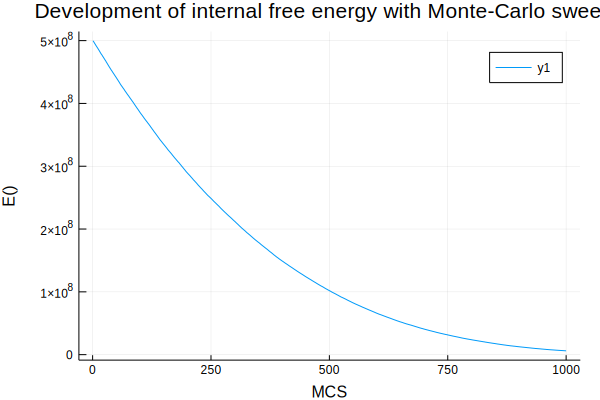

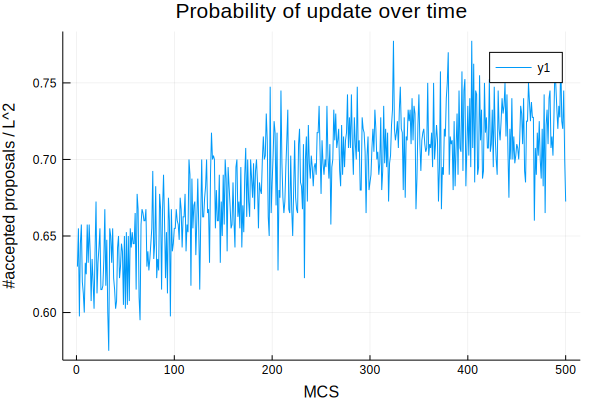

Checking if mcSweeped state is a state
Test Passed
Checking if mcSweeped state has lower energy
Test Passed
metropolisHastingUpdate! proposal was accepted 68.9±3.8% of the times
Testing if mcSweep! gives completely different state when temperature is infinite, where completely different
means that all values on all lattice sites are different. Thus we have proved that mcSweep! visits all lattice sites.
Test Passed

Testing findEquilibrium
----------------------------------------------------------------
Checking that a random state has lower energy than a completely correlated state
Test Passed


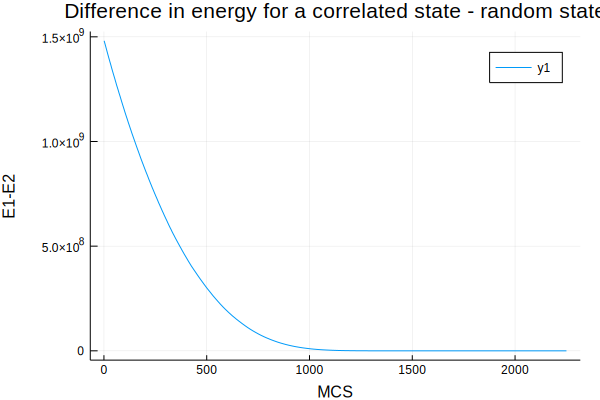

t₀ = 1572


In [34]:
########################################################################################
#                     Testing Monte Carlo functions
#
#######################################################################################

using Plots
gr()

# Create 20x20 random state.
ψ = State(20, 2)
# Testing mcSweep!
println("\nTesting mcSweep!\n----------------------------------------------------------------")
ψ_old = copy(ψ)
println("Checking if copied state is correct")
println(checkState(ψ_old))

M = 1000
E_test = zeros(M)

# Do mcSweep! M times
for i = 1:M
    mcSweep!(ψ)
    E_test[i] = E(ψ)
end
println("Checking if mcSweeped state is a state")
println(checkState(ψ))
println("Checking if mcSweeped state has lower energy")
println(@test E(ψ) < E(ψ_old))
# Plot the development of E
plt = plot(1:M, E_test, title="Development of internal free energy with Monte-Carlo sweeps", xlabel="MCS", ylabel="E()")
display(plt)

# Then we find the proposal fraction for the update
mcProposalFraction(ψ)

# At infinite energy, metropolis Hasting will always accept the new state, therefore we expect
# that after a couple of mcSweeps, the state will be completely changed
println("Testing if mcSweep! gives completely different state when temperature is infinite, where completely different
means that all values on all lattice sites are different. Thus we have proved that mcSweep! visits all lattice sites.")
L = 4
ψ = State(2, SystConstants(L, 1, 1/(0.9)^2, 0.5, 0.9/L, 0))
ψ_old = copy(ψ)
for i = 1:2
    mcSweep!(ψ)
end
isCompletelyDifferent = true
for x=1:ψ.consts.L, y=1:ψ.consts.L
    isCompletelyDifferent = isCompletelyDifferent && (ψ_old.lattice[y,x].A[1] != ψ.lattice[y,x].A[1]
        && ψ_old.lattice[y,x].A[2] != ψ.lattice[y,x].A[2] && ψ_old.lattice[y,x].θ⁺ != ψ.lattice[y,x].θ⁺ 
        && ψ_old.lattice[y,x].θ⁻ != ψ.lattice[y,x].θ⁻ && ψ_old.lattice[y,x].u⁺ != ψ.lattice[y,x].u⁺)
end
println(@test isCompletelyDifferent==true)

println("\nTesting findEquilibrium\n----------------------------------------------------------------")
consts = SystConstants(30, 1.0, 1/(0.9)^2, 0.5, 0.9/40, 1/32)
ψ₁ = State(1, consts)
ψ₂ = State(2, consts)
println("Checking that a random state has lower energy than a completely correlated state")
println(@test E(ψ₁) < E(ψ₂))
(t₀, dE, ψ₁, ψ₂) = findEquilibrium(consts)
@show t₀
T = size(dE,1)
plt = plot(1:T,dE, title="Difference in energy for a correlated state - random state", xlabel="MCS", ylabel="E1-E2")
display(plt)

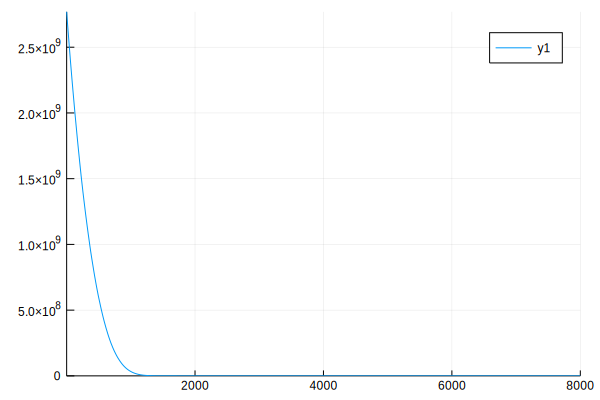

In [19]:
using Plots
gr()
T = 8000
dE_test = zeros(T)
consts = SystConstants(40, 1.0, 1/(0.9)^2, 0.5, 1.0, 1/32)
ψ₁ = State(1, consts)
ψ₂ = State(2, consts)
for i = 1:T
    dE_test[i] = E(ψ₂) - E(ψ₁)
    mcSweep!(ψ₁)
    mcSweep!(ψ₂)
end
plot(1:T, dE_test)

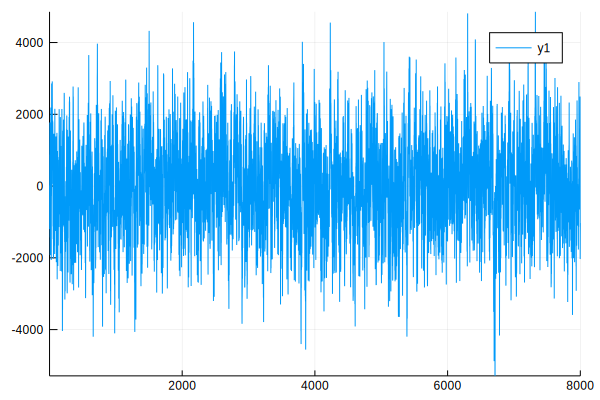

In [20]:
T = 8000
dE_test2 = zeros(T)
for i = 1:T
    dE_test2[i] = E(ψ₂) - E(ψ₁)
    mcSweep!(ψ₁)
    mcSweep!(ψ₂)
end
plot(1:T, dE_test2)

func((4π) / 3) = 2.598076211353316


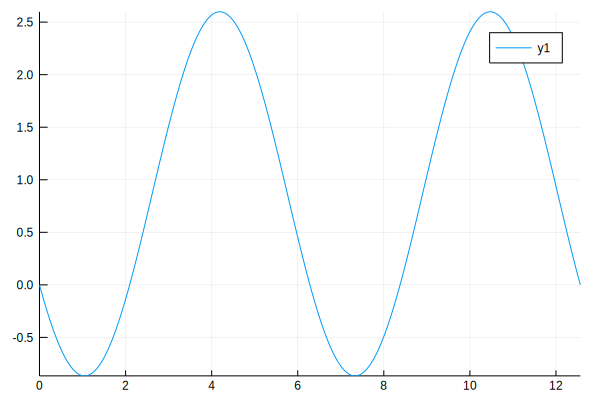

In [39]:
x = 0:0.001:4π
function func(x::Float64)
    c = 2π/3
    sin(x-c)-sin(x)+sin(c)
end
y = broadcast(func, x)
@show func(4π/3)
plot(x, y)

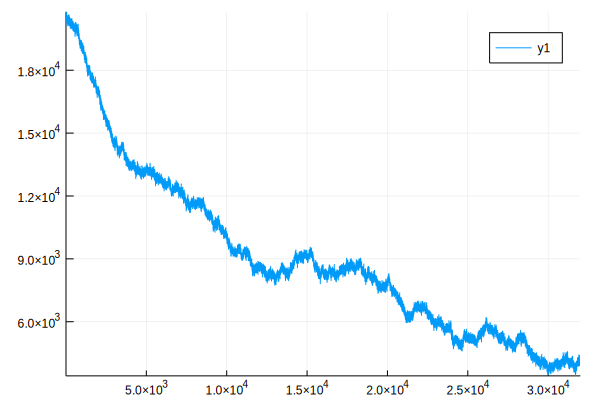

In [17]:
T = 32000
dE_test4 = zeros(T)
for i = 1:T
    dE_test4[i] = E(ψ₂) - E(ψ₁)
    mcSweep!(ψ₁)
    mcSweep!(ψ₂)
end
plot(1:T, dE_test4)

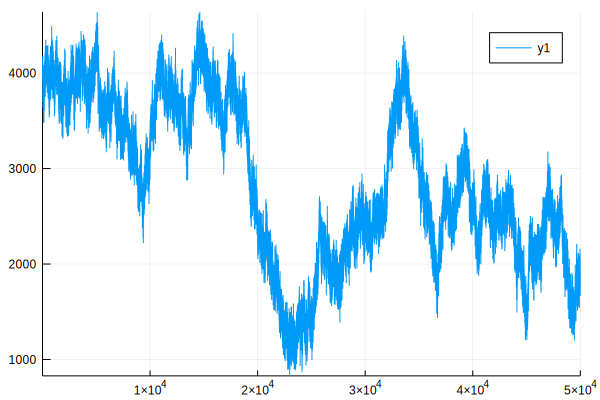

In [18]:
T = 50000
dE_test5 = zeros(T)
for i = 1:T
    dE_test5[i] = E(ψ₂) - E(ψ₁)
    mcSweep!(ψ₁)
    mcSweep!(ψ₂)
end
plot(1:T, dE_test5)

## Vorticity functions

In [55]:
####################################################################################################################
#                            Planar Structure function
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Returns the un-normalized local vorticity by preforming a plaquette sum using the gauge-invariant
# difference of the θ field.
function n⁺(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    return (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos) 
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺, two_pi) + ϕᵣ₊₂.A[1] 
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺, two_pi) + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
end
function n⁻(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    return (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos) 
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻, two_pi) + ϕᵣ₊₂.A[1] 
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻, two_pi) + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
end

# -----------------------------------------------------------------------------------------------------------
function structureFunctionPluss{T<:Real}(k::Array{T,1}, ψ::State)
    sum = Complex(0)
    L = ψ.consts.L
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return abs2(sum)
end
function structureFunctionMinus{T<:Real}(k::Array{T,1}, ψ::State)
    sum = Complex(0)
    L = ψ.consts.L
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return abs2(sum)
end
function structureFunction{T<:Real}(k::Array{T,1}, ψ::State)
    sum⁺ = Complex(0)
    sum⁻ = Complex(0)
    L = ψ.consts.L
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
        sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum⁺ += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
            sum⁻ += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return (abs2(sum⁺),abs2(sum⁻))
end

# -----------------------------------------------------------------------------------------------------------
# This version should do the same as above, but determines the neighbors dynamically at a slight cost
# to performance.
function structureFunctionPlussDyn{T<:Real}(k::Array{T,1}, ψ::State)
    L = ψ.consts.L
    sum = Complex(0.0)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    return abs2(sum)
end

structureFunctionPlussDyn (generic function with 1 method)

In [16]:
using Base.Test
########################################################################################
#                     Testing structure function sum
#
#######################################################################################
println("\nTesting structureFunctionPluss(k, ψ)\n----------------------------------------------------------------")
# First the zero test. If we set everything to 0 do we get 0 in the end?
println("Case: S(k) for θ⁺=θ⁻=A=0 with k random")
ψ = State(30, 1)
L = size(ψ.lattice,1)
ψ.consts = SystConstants(30, 1.0, 1.0, 0.5, 0, 1/300)
k = [rand(1:L)-1, rand(1:L)-1]
println(@test structureFunctionPluss(k, ψ) == 0)

# Even if we create a local vortex at [L-1,2], the sum should be zero still if k=0
println("Case: S(0) for local vortex at position [L-2, 2] while A=0")
ψ.lattice[L-1, 3].θ⁺ = π/2
ψ.lattice[L-2, 3].θ⁺ = π
ψ.lattice[L-2, 2].θ⁺ = 3π/2
println("n⁺ = -2π at [L-2,2]")
println(@test n⁺(ψ.consts,ψ.lattice[L-1,2],ψ.lattice[L-1,3],ψ.lattice[L-2,2],ψ.lattice[L-2,3], 2) == -two_pi)
println("S(0) = 0")
println(@test structureFunctionPluss([0,0], ψ) == 0)

# For a general k, we will get the expression
# Note that the order of the terms in the sum is important for getting the same floating point value.
println("Case: S(k) for local vortex at position [L-2, 2] while A=0 for random k")
res = 0.0
res -= exp(im*(k⋅getVectorPosition(L,[L,3])))*two_pi
res += exp(im*(k⋅getVectorPosition(L,[L-2, 1])))*two_pi
res += exp(im*(k⋅getVectorPosition(L,[L-2, 2])))*two_pi
res -= exp(im*(k⋅getVectorPosition(L,[L-1,2])))*two_pi
res = abs2(res)
println(@test structureFunctionPluss(k, ψ) == res)

# Finally we want to turn on the static part of the gauge field and make sure that this normalizes correctly
# when k = 0, given that all phases are again zero.
println("Checking that function gives correct normalization unnormalizedS(0) = (fL²)²")
ψ = State(L,1)
ψ.consts = SystConstants(30, 1.0, 1.0, 0.5, 1/((rand()+1)*L), 1/300)
res = (ψ.consts.f*L^2*two_pi)^2
#println(res)
#println(structureFunctionPluss([0,0],ψ))
println(@test isapprox(structureFunctionPluss([0,0], ψ),res,atol=0,rtol=1e-15*L^2))


Testing structureFunctionPluss(k, ψ)
----------------------------------------------------------------
Case: S(k) for θ⁺=θ⁻=A=0 with k random
Test Passed
Case: S(0) for local vortex at position [L-2, 2] while A=0
n⁺ = -2π at [L-2,2]
Test Passed
S(0) = 0
Test Passed
Case: S(k) for local vortex at position [L-2, 2] while A=0 for random k
Test Passed
Checking that function gives correct normalization unnormalizedS(0) = (fL²)²
Test Passed


## Observables 

In [59]:
x = 1; y = 1;
(x, y) = (2,2)
M = 10
L = 10
S = [zeros(M) for y=1:L, x=1:L]
S[1,1][1]^2

0.0

In [82]:
# -----------------------------------------------------------------------------------------------------------
function structureFunctionPlussAvg{T<:Real}(k::Array{T,1}, sim::SystConstants, M::Int64, Δt::Int64)
    S = zeros(M)
    secondMoment = 0
    s_norm = 1/(sim.f*sim.L^2*two_pi)^2
    # Finding a state that has reached thermal equilibrium
    (t₀, dE, ψ, ψ₂) = findEquilibrium(sim)
    
    # Loop over M measurements
    for m = 1:M
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ)
        end
        
        # Make a normalized measurement
        secondMoment = (S[m] = s_norm*structureFunctionPluss(k, ψ))^2
    end
    
    # Return average and error estimates
    av = mean(S)
    secondMoment = secondMoment/M
    τₒ = autocorrTime(S, 5.0)
    err = (1+2*τₒ)*(secondMoment - av^2)/(M-1)
    
    return (av, err, S)
end
# Take in a matrix of k-values and calculate both the vorticity of θ⁺ and θ⁻.
function structureFunctionAvg{T<:Real}(ks::Array{Array{T, 1}, 2}, sim::SystConstants, M::Int64, Δt::Int64)
    Lky = size(ks, 1)
    Lkx = size(ks, 2)
    S⁺ = [zeros(M) for y=1:Lky, x=1:Lkx]    # Matrix containing the series of measurements for each k
    S⁻ = [zeros(M) for y=1:Lky, x=1:Lkx]
    Sm⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    Sm⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    s_norm_inv = 1/(sim.f*sim.L^2*two_pi)^2
    
    # Finding a state that has eached thermal equilibrium
    println("Finding equilibrium")
    (t₀, dE, ψ, ψ₂) = findEquilibrium(sim)
    
    prinln("Making measurements")
    # Loop over M measurements
    for m = 1:M
        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ)
        end
        
        # Make measurements 
        for y = 1:Lky, x = 1:Lkx
            (S⁺[y,x][m], S⁻[y,x][m]) = structureFunction(ks[y,x], ψ)
            Sm⁺[y,x] += S⁺[y,x][m]^2
            Sm⁻[y,x] += S⁻[y,x][m]^2
        end
    end
    
    # Return average and error estimates
    avS⁺ = [mean(S⁺[y,x]) for y=1:Lky, x=1:Lkx]
    avS⁻ = [mean(S⁻[y,x]) for y=1:Lky, x=1:Lkx]
    τ⁺ = [autocorrTime(S⁺[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    τ⁻ = [autocorrTime(S⁻[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    errS⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    errS⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    
    for y=1:Lky, x=1:Lkx
        Sm⁺[y,x] /= M
        Sm⁻[y,x] /= M
        errS⁺[y,x] = (1+2*τ⁺[y,x])*(Sm⁺[y,x] - avS⁺[y,x]^2)/(M-1)
        errS⁻[y,x] = (1+2*τ⁻[y,x])*(Sm⁻[y,x] - avS⁻[y,x]^2)/(M-1)
    end
    
    return (avS⁺, errS⁺, avS⁻, errS⁻)
end

structureFunctionAvg (generic function with 2 methods)

## Testing Observables
Now we run some measurements to check if this works successfully
We see that in Garaud et. al. they use the parameters
$$g = 0.3,\quad\nu = 0.3,\quad|H|= 0.72$$

What happens after 2000 number of MCS


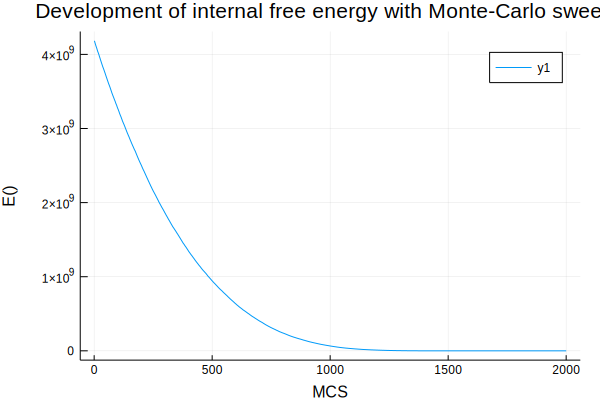

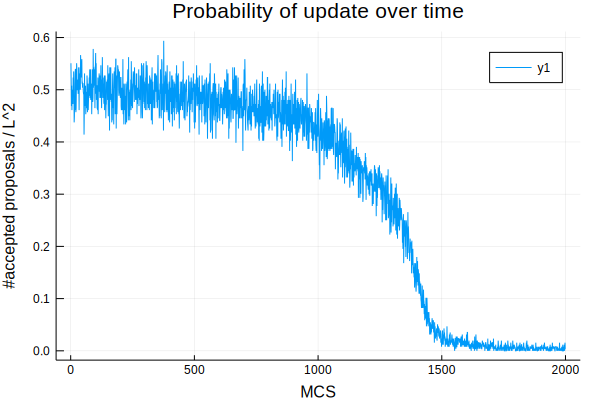

Checking if mcSweeped state has lower energy
Test Passed
metropolisHastingUpdate! proposal was accepted 31.0±20.5% of the times
Testing if mcSweep! gives completely different state when temperature is infinite, where completely different
    means that all values on all lattice sites are different. Thus we have proved that mcSweep! visits all lattice sites.
Test Passed

Equilibrium calculation
----------------------------------------------------------------
Checking that a random state has lower energy than a completely correlated state
Test Passed


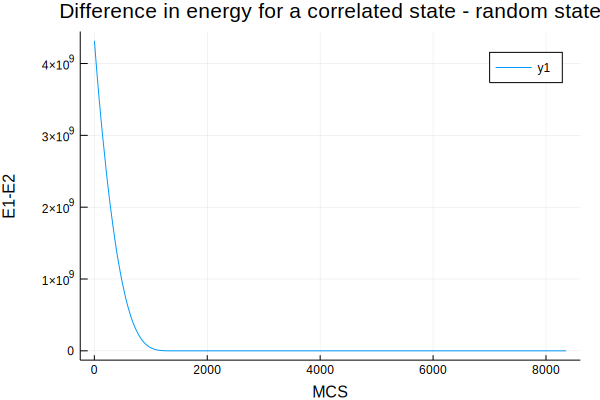

t₀ = -1


In [43]:
using Plots
gr()

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 16     # System length
T = 0.12   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 100    # Number of measurements
Δt = 400  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
testSystem(syst)

In [40]:
function latticeCompletelyDifferent(ψ₁::State, ψ₂::State)
    ψ₁.consts.L == ψ₂.consts.L || throw(DomainError())
    isCompletelyDifferent = true
    for x=1:ψ₂.consts.L, y=1:ψ₂.consts.L
        isCompletelyDifferent = isCompletelyDifferent && (ψ₁.lattice[y,x].A[1] != ψ₂.lattice[y,x].A[1]
            && ψ₁.lattice[y,x].A[2] != ψ₂.lattice[y,x].A[2] && ψ₁.lattice[y,x].θ⁺ != ψ₂.lattice[y,x].θ⁺ 
            && ψ₁.lattice[y,x].θ⁻ != ψ₂.lattice[y,x].θ⁻ && ψ₁.lattice[y,x].u⁺ != ψ₂.lattice[y,x].u⁺)
    end
    return isCompletelyDifferent
end
# Testing how well our algorithms work for this choice of parameters.
function testSystem(syst::SystConstants, M::Int64=2000)
    # Let's first look at the time it takes to equilibrate the state
    ψ = State(2, syst)
    ψ_old = copy(ψ)
    
    println("What happens after $(M) number of MCS")
    E_test = zeros(M)

    # Do mcSweep! M times
    for i = 1:M
        mcSweep!(ψ)
        E_test[i] = E(ψ)
    end
    println("Checking if mcSweeped state has lower energy")
    println(@test E(ψ) < E(ψ_old))
    plt = plot(1:M, E_test, title="Development of internal free energy with Monte-Carlo sweeps", 
        xlabel="MCS", ylabel="E()")
    display(plt)
    
    # Then we find the proposal fraction for the update
    mcProposalFraction(ψ_old, M)
    
    # At infinite energy, metropolis Hasting will always accept the new state, therefore we expect
    # that after a couple of mcSweeps, the state will be completely changed
    println("Testing if mcSweep! gives completely different state when temperature is infinite, where completely different
    means that all values on all lattice sites are different. Thus we have proved that mcSweep! visits all lattice sites.")
    ψ = State(2, SystConstants(syst.L, syst.γ, syst.g⁻², syst.ν, syst.f, 0))
    ψ_old = copy(ψ)
    for i = 1:2
        mcSweep!(ψ)
    end
    println(@test latticeCompletelyDifferent(ψ,ψ_old))

    println("\nEquilibrium calculation\n----------------------------------------------------------------")
    ψ₁ = State(1, syst)
    ψ₂ = State(2, syst)
    println("Checking that a random state has lower energy than a completely correlated state")
    println(@test E(ψ₁) < E(ψ₂))
    flush(STDOUT)
    (t₀, dE, ψ₁, ψ₂) = findEquilibrium(syst, M)
    @show t₀
    T = size(dE,1)
    plt = plot(1:T,dE, title="Difference in energy for a correlated state - random state", xlabel="MCS", ylabel="E1-E2")
    display(plt)
end

testSystem (generic function with 2 methods)

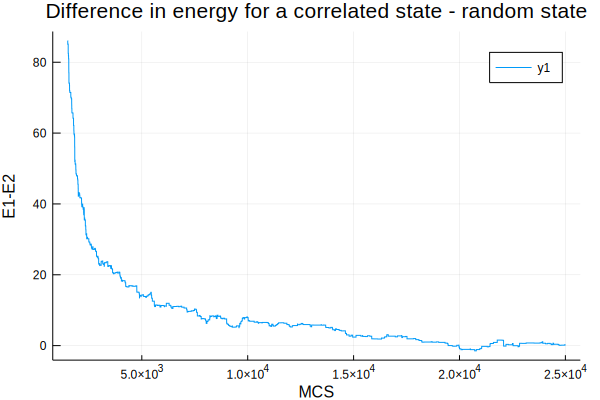

In [116]:
plt = plot(1500:25000,dE[1500:25000], title="Difference in energy for a correlated state - random state",
    xlabel="MCS", ylabel="E1-E2")

In [ ]:

# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]

# Calculate thermal average
(avS⁺, errS⁺, avS⁻, errS⁻) = structureFunctionAvg(k_matrix, syst, M, Δt)

# Plot result for + component
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺)
